# Background
This document describes how to do the variant filtering of a VCF format file generated using BCFTools [[1]](https://samtools.github.io/bcftools/). The approach followed consists on using a supervised machine learning method for the filtering, more specifically we will use different binary classifiers and we will assess the performance on a test dataset in order to decide which is superior.

# Data used
In this document we have used a VCF file generated for sample NA12878 using the sequencing data generated for the 1000 Genomes Project. The callset in the VCF file was generated using BCFTools.

# Traning the model
We are going to use the sites in our callset for chr20 that are also found by GIAB NA12878 [[2]](https://github.com/genome-in-a-bottle). GIAB sequenced NA12878 using 13 different sequencing technologies and analysis methods, so the GIAB callset is considered as the gold standard callset and this is why we considered the variants identified by GIAB and us as true sites that are useful to train the model. We will train the classifier independently for the SNPs and the INDELs

## Annotations used for the filtering exercise
BCFTools annotates each of the identified variants with a set of features used as predictors for our model. The variant annotations used are:


## SNPs
We are going to use two different SNP VCFs, one has all the sites identified both by GIAB and us (`TP.chr20.vcf.gz`) and the other was identified by us and not by GIAB and are considered False Positive sites (`FP.chr20.vcf.gz`). Then we extract the annotations for each of the files by doing:

Now, we read-in the annotations in each of the files into a Pandas dataframe

In [43]:
import pandas as pd

%matplotlib inline

col_names=['chr','pos','DP','RPB','MQB','BQB','MQSB','SGB','MQ0F','ICB','HOB',
           'DP4','MQ']

# read-in the data frame from tsv file
DF_TP=pd.read_csv('/Users/ernesto/SCRATCH/VARIANT_FILTERING/TP_annotations.tsv',sep="\t",
               names=col_names)
DF_FP=pd.read_csv('/Users/ernesto/SCRATCH/VARIANT_FILTERING/FP_annotations.tsv',sep="\t",
               names=col_names)

Now we will add a new column named `is_valid` to our two dataframes that will be 1 if the variant is real and will be 0 when the variant is a false positive. This new column will be the dependent binary variable in our classifier

In [44]:
DF_TP=DF_TP.assign(is_valid=1)
DF_FP=DF_FP.assign(is_valid=0)

And now we combine the two dataframes into a single dataframe:

In [46]:
frames = [DF_TP,DF_FP]
DF = pd.concat(frames)
print(DF)

        chr       pos     DP          RPB          MQB          BQB  \
0     chr20     68303  17127     0.794352            0  3.57131e-16   
1     chr20     72982  17678    0.0635767            0    0.0368648   
2     chr20     73765  17910  0.000533952            0            0   
3     chr20     77005  19513     0.911788            0  4.80673e-11   
4     chr20     78705  20994     0.890914            0    0.0353932   
5     chr20     80457  18725     0.994843            0     0.101913   
6     chr20     81154  22406     0.965516            0  1.04771e-14   
7     chr20     82603  18458      0.69988            0     0.763813   
8     chr20     83158  21736     0.754186            0            0   
9     chr20     85259  23468     0.162256            0            0   
10    chr20     85729  19689     0.757914            0  8.31719e-18   
11    chr20     88108  21684   0.00837126            0            0   
12    chr20     92251  15036     0.997864            0     0.606669   
13    

### Initial exploration of the data
First, let's examine the number of records having `is_valid=1` (i.e. True positive) and `is_valid=0` (i.e. False Positive) 

In [37]:
DF.iloc[:,13].value_counts()

1    59429
0     2439
Name: is_valid, dtype: int64

Let's examine the distribution of the different predictors depending on the `is_valid` variable.

* DP (Raw read depth)

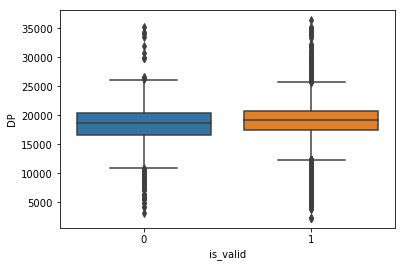

In [38]:
import seaborn as sns
ax = sns.boxplot(x="is_valid", y="DP", data=DF)

* Mean for each category

In [39]:
DF.groupby("is_valid").agg({'DP': 'mean'})

,DP
is_valid,
0,18278.812628
1,18927.924296


* Median for each category

In [41]:
DF.groupby("is_valid").agg({'DP': 'median'})

,DP
is_valid,
0,18676
1,19226


* RPB (Mann-Whitney U test of Read Position Bias (bigger is better))

KeyboardInterrupt: 

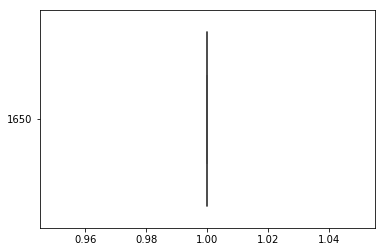

In [42]:
ax = sns.boxplot(x="is_valid", y="RPB", data=DF)